<a href="https://colab.research.google.com/github/minhha0510/StackOverflow-datascience-question/blob/main/Data_science_project_scrap_info_from_Stackoverflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Executive summary

### The problem
I tried to answer: *"What is it that people want to learn about in data science?"*

### The approach

Data source: I decided to use StackExchange, one of the most popular forums for people to ask questions about DataScience and Programming in general.

I first categorize the broad subject based on "tags" data from StackOverflow. From there, I further niched down to identify the specific topics

The steps in data analysis process are:
1. Data exploration
2. Data cleaning
3. Exploring the most popular tags
4. Engaging domain knowledge

### Result

`Deep learning` is the topic has demonstrated a substaintial interest since 2014. The analysis also identifies 46 specific topics related to `Deep learning` for writing learning materials. 

## Data exploration

StackExchange provides "Query Data" that uses SQL as the main query language. I extracted *6155 rows* by using the following code 

```
SELECT Id, CreationDate, 
       Score, ViewCount, 
       Tags, AnswerCount, 
        FavoriteCount
FROM posts
WHERE PostTypeId = 1
AND CreationDate LIKE '%2020%';
```
PostyTypeId = 1 is the id for posts that are questions and answers

In [1]:
#loading the packages
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import operator
from functools import reduce

In [2]:
url =  'https://raw.githubusercontent.com/minhha0510/StackOverflow-datascience-question/main/2020-2021%20stackoverflow%20data.csv'
 

In [3]:
%matplotlib inline
StackExchange = pd.read_csv(url)

In [4]:
# Explore the data
# We can see "favourite count" and "accepted answerId" columns have a lot of missing values
StackExchange.info()
StackExchange.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6155 entries, 0 to 6154
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Id                6155 non-null   int64  
 1   CreationDate      6155 non-null   object 
 2   Score             6155 non-null   int64  
 3   ViewCount         6155 non-null   int64  
 4   Tags              6155 non-null   object 
 5   AnswerCount       6155 non-null   int64  
 6   FavoriteCount     1059 non-null   float64
 7   AcceptedAnswerId  2021 non-null   float64
dtypes: float64(2), int64(4), object(2)
memory usage: 384.8+ KB


,Id,CreationDate,Score,ViewCount,Tags,AnswerCount,FavoriteCount,AcceptedAnswerId
0,76867,2020-06-29 19:10:11,2,142,<classification><supervised-learning>,0,NaN,NaN
1,76868,2020-06-29 19:17:25,3,86,<clustering><imbalance>,1,NaN,NaN
2,76870,2020-06-29 19:58:26,1,98,<machine-learning><classification><dataset><fe...,1,NaN,NaN
3,76872,2020-06-29 20:55:34,1,1363,<nlp><bert><transformer>,4,NaN,NaN
4,76873,2020-06-29 21:17:53,2,104,<machine-learning><r><bootstraping>,2,NaN,NaN


Number of questions asked in 2020:  6155


MISSING VALUES %:
Id                   0.0
CreationDate         0.0
Score                0.0
ViewCount            0.0
Tags                 0.0
AnswerCount          0.0
FavoriteCount       83.0
AcceptedAnswerId    67.0
dtype: float64


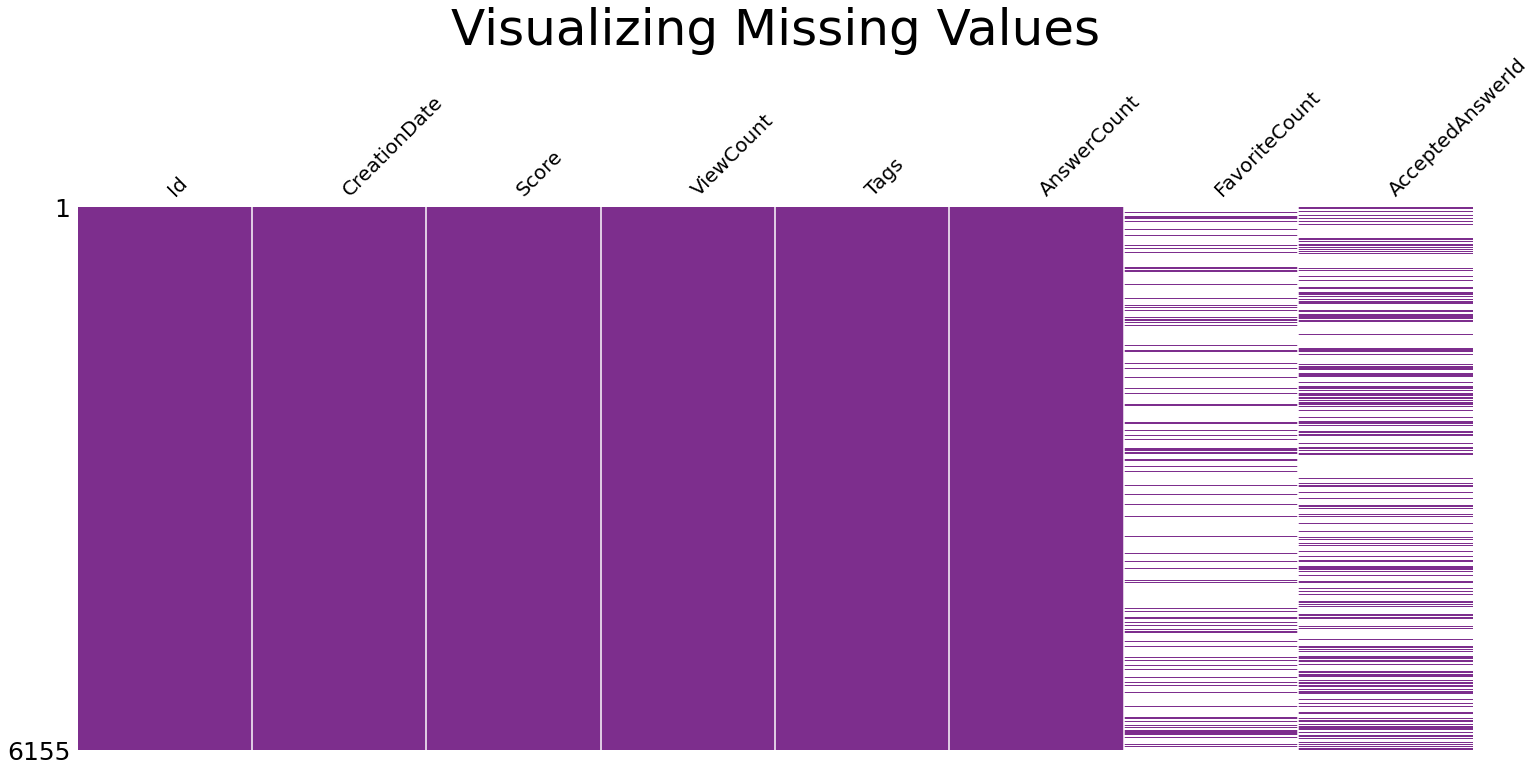

In [5]:
# Checking the number of entries
print('Number of questions asked in 2020: ', len(StackExchange))
print('\n')

# Checking missing values
print(
      f'MISSING VALUES %:\n{round(100 * StackExchange.isnull().sum()/len(StackExchange))}'
      )

# Visualizing missing values by means of the missingno library
msno.matrix(
            StackExchange, 
            fontsize=20, 
            color=(0.494, 0.184, 0.556), 
            sparkline=False,
            inline=False
            ) 
plt.title('Visualizing Missing Values', fontsize= 50)
plt.show()

From their website, each column roughly means the following:
* __Id__: An identification number for the post.
* __CreationDate__: The date and time of creation of the post.
* __Score__: The post's score.
* __ViewCount__: How many times the post was viewed.
* __Tags__: What tags were used.
* __AnswerCount__: How many answers the question got (only applicable to question posts).
* __FavoriteCount__: How many times the question was favored (only applicable to question posts).

The __Tags__ column will be critical for our analysis, as it tells us subjectively what each post is about. We will have to find a way to parse out the tags for each post, of which there can be none or several. 

The __Score__, __ViewCount__, __AnswerCount__, and __FavoriteCount__ columns will give us engagement metrics.

The __CreationDate__ column will give us a sense of any seasonality.

## Data cleaning

In [6]:
# Check missing values in FavoriteCount
StackExchange['FavoriteCount'].value_counts(dropna=False).sort_index(ascending=False)

15.0       1
14.0       1
12.0       1
9.0        1
8.0        3
7.0        3
6.0        7
5.0        8
4.0       12
3.0       37
2.0      134
1.0      738
0.0      113
NaN     5096
Name: FavoriteCount, dtype: int64

In [7]:
# Drop the Accepeted Answer ID column
# Dropping the column 
StackExchange = StackExchange.drop(['AcceptedAnswerId'], axis=1)

In [8]:
# Fill the missing values with 0
StackExchange["FavoriteCount"].fillna(0,inplace = True)

In [9]:
# Check the changes
StackExchange['FavoriteCount'].value_counts(dropna=False).sort_index(ascending=False)
# 23945 + 582 = 24527

15.0       1
14.0       1
12.0       1
9.0        1
8.0        3
7.0        3
6.0        7
5.0        8
4.0       12
3.0       37
2.0      134
1.0      738
0.0     5209
Name: FavoriteCount, dtype: int64

In [10]:
#Set the types of each column 
StackExchange["FavoriteCount"] = StackExchange["FavoriteCount"].astype(int)
StackExchange["CreationDate"] = pd.to_datetime(StackExchange["CreationDate"])
StackExchange.info()
StackExchange["Tags"].head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6155 entries, 0 to 6154
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Id             6155 non-null   int64         
 1   CreationDate   6155 non-null   datetime64[ns]
 2   Score          6155 non-null   int64         
 3   ViewCount      6155 non-null   int64         
 4   Tags           6155 non-null   object        
 5   AnswerCount    6155 non-null   int64         
 6   FavoriteCount  6155 non-null   int64         
dtypes: datetime64[ns](1), int64(5), object(1)
memory usage: 336.7+ KB


0                <classification><supervised-learning>
1                              <clustering><imbalance>
2    <machine-learning><classification><dataset><fe...
3                             <nlp><bert><transformer>
4                  <machine-learning><r><bootstraping>
Name: Tags, dtype: object

The __Tags data__ should be converted to a __string__ format that is conducive to analysis techniques. We will change from <tag> to comma separated values so we can use list manipulation techniques.

In [11]:
#Clean the Tags column and assign it back to itself
StackExchange["Tags"] = StackExchange["Tags"].str.replace("^<","").str.replace(">$","").str.split("><")
StackExchange["Tags"].head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  


0                [classification, supervised-learning]
1                              [clustering, imbalance]
2    [machine-learning, classification, dataset, fe...
3                             [nlp, bert, transformer]
4                  [machine-learning, r, bootstraping]
Name: Tags, dtype: object

## Exploring the most popular tags


In [12]:
#Count how many times each tag was used.
tag_count = dict()
for tags in StackExchange["Tags"]:
    for tag in tags:
        if tag in tag_count:
            tag_count[tag] += 1
        else:
            tag_count[tag] = 1

print(tag_count)

{'classification': 542, 'supervised-learning': 60, 'clustering': 211, 'imbalance': 4, 'machine-learning': 1887, 'dataset': 246, 'feature-selection': 171, 'audio-recognition': 17, 'nlp': 496, 'bert': 81, 'transformer': 73, 'r': 191, 'bootstraping': 7, 'word-embeddings': 91, 'sentiment-analysis': 41, 'neural-network': 704, 'keras': 549, 'time-series': 292, 'prediction': 85, 'forecasting': 71, 'word2vec': 52, 'embeddings': 40, 'representation': 14, 'deep-learning': 841, 'cnn': 282, 'loss-function': 114, 'regression': 310, 'statistics': 209, 'visualization': 103, 'predictive-modeling': 177, 'linear-regression': 142, 'correlation': 80, 'collinearity': 10, 'rnn': 128, 'probability-calibration': 13, 'python': 1205, 'random-forest': 174, 'distributed': 3, 'tokenization': 14, 'hashingvectorizer': 2, 'data-mining': 127, 'feature-engineering': 120, 'recommender-system': 73, 'ranking': 28, 'ndcg': 3, 'data-analysis': 64, 'scikit-learn': 438, 'k-means': 80, 'probability': 62, 'density-estimation': 

In [13]:
#converts dictionary into a DataFrame         
tag_count_df = pd.DataFrame.from_dict(tag_count, orient = "index").reset_index()
tag_count_df.columns = ['Tag', "Counts"]
tag_count_df.head()

#sort values in ascending mode
most_used_tags = tag_count_df.sort_values("Counts", ascending = False ).head(20)
most_used_tags.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20 entries, 4 to 36
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Tag     20 non-null     object
 1   Counts  20 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 480.0+ bytes


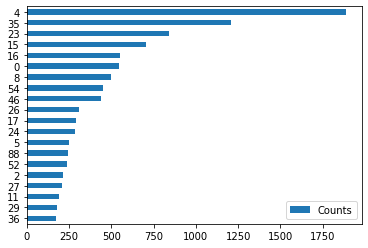

In [14]:
#Create visualization for most used tags
ax = most_used_tags.plot.barh()
ax.invert_yaxis()
plt.show()

In [15]:
#Count how many times each tag was viewed
tag_views = dict()
# iterrows allows us to loop through each row in a dataframe
for index, row in StackExchange.iterrows():
  # loop through the list of each row
    for tag in row["Tags"]:
        if tag in tag_views:
            tag_views[tag] += row["ViewCount"]
        else:
            tag_views[tag] = row["ViewCount"]

#converts dictionary into a DataFrame         
tag_views_df = pd.DataFrame.from_dict(tag_views, orient = "index").reset_index() 
tag_views_df.columns = ['Tag', "Views"]
tag_views_df.head()
print(tag_views_df)

#sort values in ascending mode
most_viewed_tags = tag_views_df.sort_values("Views", ascending = False ).head(20)
most_viewed_tags.info()

                         Tag   Views
0             classification  185717
1        supervised-learning   16957
2                 clustering   64525
3                  imbalance    2027
4           machine-learning  744143
..                       ...     ...
552  multi-instance-learning      32
553            serialisation      29
554               hinge-loss     705
555              open-source      54
556           lda-classifier      34

[557 rows x 2 columns]
<class 'pandas.core.frame.DataFrame'>
Int64Index: 20 entries, 35 to 26
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Tag     20 non-null     object
 1   Views   20 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 480.0+ bytes


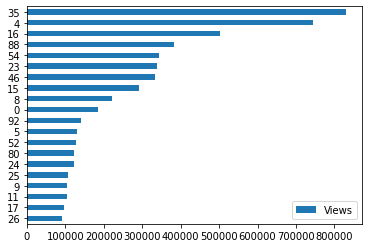

In [16]:
#Create visualization for most viewed tags
ax2 = most_viewed_tags.plot.barh()
ax2.invert_yaxis()
plt.show()

It will be useful indicator of popularity for us to know which tags are present in both the top 20 usage count and view count dataframes. Let's combine our dataframes to see which are in both and how they rank.

In [17]:
views_in_usage_count = pd.merge(left = most_used_tags, right = most_viewed_tags, how = 'left', left_index=True, right_index = True )
usage_count_in_views = pd.merge(left = most_viewed_tags, right = most_used_tags, how = 'left', left_index=True, right_index = True)

In [18]:
print(views_in_usage_count)

                  Tag_x  Counts             Tag_y     Views
4      machine-learning    1887  machine-learning  744143.0
35               python    1205            python  829701.0
23        deep-learning     841     deep-learning  339187.0
15       neural-network     704    neural-network  291458.0
16                keras     549             keras  503268.0
0        classification     542    classification  185717.0
8                   nlp     496               nlp  222458.0
54           tensorflow     451        tensorflow  343596.0
46         scikit-learn     438      scikit-learn  332876.0
26           regression     310        regression   91165.0
17          time-series     292       time-series   97638.0
24                  cnn     282               cnn  121466.0
5               dataset     246           dataset  129686.0
88               pandas     241            pandas  381982.0
52                 lstm     235              lstm  127146.0
2            clustering     211         

In [19]:
print(usage_count_in_views)

               Tag_x   Views             Tag_y  Counts
35            python  829701            python  1205.0
4   machine-learning  744143  machine-learning  1887.0
16             keras  503268             keras   549.0
88            pandas  381982            pandas   241.0
54        tensorflow  343596        tensorflow   451.0
23     deep-learning  339187     deep-learning   841.0
46      scikit-learn  332876      scikit-learn   438.0
15    neural-network  291458    neural-network   704.0
8                nlp  222458               nlp   496.0
0     classification  185717    classification   542.0
92         dataframe  139632               NaN     NaN
5            dataset  129686           dataset   246.0
52              lstm  127146              lstm   235.0
80        python-3.x  122718               NaN     NaN
24               cnn  121466               cnn   282.0
25     loss-function  107395               NaN     NaN
9               bert  105183               NaN     NaN
11        

In [20]:
dataframes_top20 = [
                    most_used_tags, 
                    most_viewed_tags,
                    ]
top20_merged = reduce(lambda left,right: pd.merge(
                                                  left,right,on=['Tag'],
                                                  how='inner'), 
                                         dataframes_top20)
print('Number of tags occured in all the TOP20 dataframes: ', 
      len(top20_merged))
top20_merged

Number of tags occured in all the TOP20 dataframes:  16


,Tag,Counts,Views
0,machine-learning,1887,744143
1,python,1205,829701
2,deep-learning,841,339187
3,neural-network,704,291458
4,keras,549,503268
5,classification,542,185717
6,nlp,496,222458
7,tensorflow,451,343596
8,scikit-learn,438,332876
9,regression,310,91165


Hence, in all the TOP20 dataframes, there are 16 out of 20 tags in common. We're going to plot these 16 most popular tags together with the corresponding values of their popularuty measures, but since they all have quite different ranges, it's necessary to __normalize__ them first. 

In [21]:
top20_merged_normalized = top20_merged.copy()
columns = top20_merged_normalized.columns.tolist()[1:]
for column in columns:
    top20_merged_normalized[column] =\
    top20_merged_normalized[column] / top20_merged_normalized[column].abs().max() 
  
print(top20_merged_normalized)

                 Tag    Counts     Views
0   machine-learning  1.000000  0.896881
1             python  0.638580  1.000000
2      deep-learning  0.445681  0.408806
3     neural-network  0.373079  0.351281
4              keras  0.290938  0.606565
5     classification  0.287228  0.223836
6                nlp  0.262851  0.268118
7         tensorflow  0.239004  0.414120
8       scikit-learn  0.232114  0.401200
9         regression  0.164282  0.109877
10       time-series  0.154743  0.117679
11               cnn  0.149444  0.146397
12           dataset  0.130366  0.156305
13            pandas  0.127716  0.460385
14              lstm  0.124536  0.153243
15                 r  0.101219  0.126579


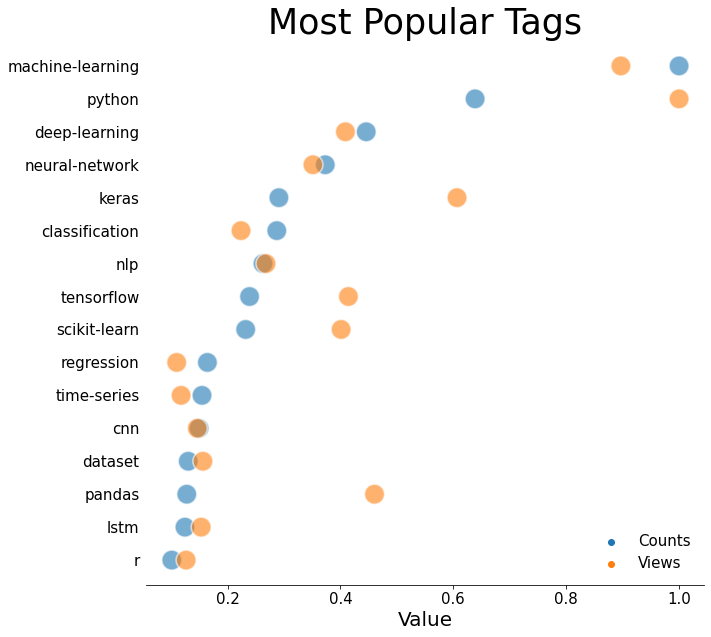

In [22]:
# Creating a melted dataframe from the merged dataframe for further plotting
top20_melted = pd.melt(
                       top20_merged_normalized, 
                       id_vars=['Tag'], 
                       value_vars=columns
                       )

# Renaming columns
top20_melted.columns = ['Tag', 'PopularityMeasure', 'Value']

# Creating a dot plot for the most popular tags
fig, ax = plt.subplots(figsize=(10,10))
ax = sns.scatterplot(
                     data=top20_melted, 
                     x='Value', 
                     y='Tag', 
                     hue='PopularityMeasure',
                     s=400,
                     alpha=0.6
                     )
ax.set_title('Most Popular Tags', fontsize=35)
ax.set_xlabel('Value', fontsize=20)
ax.set_ylabel(None)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
ax.tick_params(left=False)
ax.legend(loc=4, fontsize=15, frameon=False)
sns.despine(left=True)
plt.show()

## Engaging domain knowledge


All the visualizations so far showed that `machine-learning` is the most popular tag, with a big gap from all the others. This gives us a general trend, however we have to take into account that the sphere of **machine learning** itself is rather large and includes plenty of branches, approaches, and methods.

At a closer look, we see that all the topics reflected by the 9 most popular tags above are actually all interrelated, and all can be united under a general giant topic: **Machine Learning**.

> As of 2020, deep learning has become the dominant approach for much ongoing work in the field of machine learning.

Hence, being a relatively new, rising area, attracting more and more interest from both learners and data scientists, still quite a large topic, but already much more focused than machine learning in general, **deep learning seems to be a perfect candidate for a data science learning resource content**.

Before finalizing our recommendation, we need to check `"Is deep learning just a fad?"` before investing the time and resources into writing learning materials.

To track the interest in this topic across time, we're going to return to the DSSE database and run a query that fetches all of the questions ever asked on DSSE, their dates and tags:
```
SELECT Id, 
       CreationDate, 
       Tags
  FROM posts
 WHERE PostTypeId = 1;
```

In [23]:
url_1 = 'https://raw.githubusercontent.com/minhha0510/StackOverflow-datascience-question/main/Deep%20learning%20interest%20over%20time.csv'

questions_all = pd.read_csv(url_1, parse_dates=['CreationDate'])
questions_all.head()

,Id,CreationDate,Tags
0,5,2014-05-13 23:58:30,<machine-learning>
1,7,2014-05-14 00:11:06,<education><open-source>
2,14,2014-05-14 01:25:59,<data-mining><definitions>
3,15,2014-05-14 01:41:23,<databases>
4,16,2014-05-14 01:57:56,<machine-learning><bigdata><libsvm>


In [24]:
# Transforming values in the `Tags` column into lists of strings
questions_all['Tags'] = questions_all['Tags'].str.replace("^<|>$","").str.split("><")

# Double-checking the results
questions_all.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  


,Id,CreationDate,Tags
0,5,2014-05-13 23:58:30,[machine-learning]
1,7,2014-05-14 00:11:06,"[education, open-source]"
2,14,2014-05-14 01:25:59,"[data-mining, definitions]"
3,15,2014-05-14 01:41:23,[databases]
4,16,2014-05-14 01:57:56,"[machine-learning, bigdata, libsvm]"


In [25]:
# Creating a list of all the tags ever used
all_tags = []
for lst in questions_all['Tags']:
    for item in lst:
        if item not in all_tags:
            all_tags.append(item)

# Creating a list of sets of tags for each question that has `deep-learning`
# as one of the tags
dl_tags = []
for lst in questions_all['Tags']:
    if 'deep-learning' in lst:
        dl_tags.append(lst)

# Creating a dictionary of all the tags used in combination with `deep-learning`
# and their frequencies
dl_tags_dict = {}
for lst in dl_tags:
    for item in lst:
        if item not in dl_tags_dict:
            dl_tags_dict[item]=0
        dl_tags_dict[item] += 1

# Sorting the dictionary
sorted_dl_tags_dict= dict(sorted(
                                 dl_tags_dict.items(), 
                                 reverse=True, 
                                 key=operator.itemgetter(1)
                                 ))
                                 
# Creating a list of all the tags that were used with the `deep-learning` tag,
# but sometimes were used also without it
dl_tags_not_exclusive = []
for lst in questions_all['Tags']:
    for item in list(dl_tags_dict.keys())[1:]: # avoiding checking `deep-learning` itself
         if 'deep-learning' not in lst and item in lst and item not in dl_tags_not_exclusive:
                dl_tags_not_exclusive.append(item)

# Printing the statistics and the dictionary
print('Number of all the questions in the DSSE:',  '\n',
      len(questions_all), '\n', '\n',
      'Number of questions with the `deep-learning` tag:', '\n', 
      len(dl_tags), '\n', '\n',
      'Overall number of all the tags in the DSSE database:', '\n', 
      len(all_tags), '\n', '\n',
      'Number of unique tags associated with `deep-learning`:',  '\n', 
      len(dl_tags_dict), '\n','\n',
      'Number of unique tags associated with `deep-learning`, but sometimes used without:', '\n',
      len(dl_tags_not_exclusive), '\n', '\n',  
      sorted_dl_tags_dict)

Number of all the questions in the DSSE: 
 32379 
 
 Number of questions with the `deep-learning` tag: 
 4339 
 
 Overall number of all the tags in the DSSE database: 
 659 
 
 Number of unique tags associated with `deep-learning`: 
 421 
 
 Number of unique tags associated with `deep-learning`, but sometimes used without: 
 415 
 
 {'deep-learning': 4339, 'machine-learning': 1792, 'neural-network': 1313, 'keras': 790, 'tensorflow': 623, 'python': 516, 'cnn': 489, 'nlp': 329, 'lstm': 290, 'classification': 288, 'convolutional-neural-network': 260, 'computer-vision': 240, 'image-classification': 198, 'rnn': 190, 'time-series': 156, 'pytorch': 136, 'reinforcement-learning': 122, 'dataset': 115, 'convolution': 113, 'object-detection': 105, 'training': 102, 'loss-function': 97, 'autoencoder': 88, 'regression': 88, 'data-mining': 86, 'gan': 85, 'machine-learning-model': 76, 'transformer': 70, 'predictive-modeling': 67, 'image-recognition': 63, 'gradient-descent': 63, 'data-science-model': 6

From the statistics above, we can make the following observations:
-  13% of all the questions in the DSSE database are tagged with `deep-learning`,
- 62% of all the unique tags were ever used in combination with `deep-learning`,
- **almost all of the tags (99%) associated with `deep-learning` were used at least once without it**. 

The last insight is especially important for us, since it means that there definitely should be some questions not tagged with `deep-learning`, but having some other tags strongly related to the deep learning sphere (for example, representing some specific libraries or methods). Hence, returning to the 1st observation, in reality we should have more (presumably, much more) than 13% of questions related to deep-learning.

Our next step is exactly to find those tags specific only to the deep learning sphere. Since the dictionary of the unique tags associated with the `deep-learning` tag contains quite a big but still manageable amount of items (381), we can decide not to apply correlation techniques, but instead try to deal with these tags manually. Despite this approach is definitely more time-consuming, we can ensure getting more value out of the data. The algorithm is the following:
- Excluding generic and obviously non-specific tags (fortunately for our task, there are quite a lot of them: `kaggle`, `education`, `java`, `parsing`, `career`, etc.). This includes also `machine-learning` and `python`.
- Excluding the tags that can be related both to deep learning and to the "classical" machine learning: `k-nn`, `classifier`, `roc`, `overfitting`, `logistic-regression`, `scikit-learn`, etc. At this step, we'll use our domain knowledge and google information in all ambiguous cases. The idea here is to be rather conservative and keep **only** those tags that are **uniquely related to deep learning**.

Below is the resulting dictionary:

In [26]:
dl_related_tags = {
                   'deep-learning': 3544,
                   'neural-network': 1143,
                   'keras': 665,
                   'cnn': 409,
                   'lstm': 240,
                   'convnet': 191,
                   'rnn': 133,
                   'autoencoder': 77,
                   'gan': 71,
                   'recurrent-neural-net': 55,
                   'backpropagation': 54,
                   'activation-function': 48,
                   'gpu': 42,
                   'deep-network': 39,
                   'dqn': 30,
                   'yolo': 28,
                   'mlp': 24,
                   'attention-mechanism': 23,
                   'dropout': 22,
                   'vgg16': 15,
                   'inception': 14,
                   'mini-batch-gradient-descent': 12,
                   'faster-rcnn': 11,
                   'gru': 10,
                   'caffe': 10,
                   'perceptron': 8,
                   'rbm': 8,
                   'stacked-lstm': 6,
                   'inceptionresnetv2': 6,
                   'ann': 6,
                   'alex-net': 6,
                   'siamese-networks': 5,
                   'neural-style-transfer': 4,
                   'pooling': 4,
                   'graph-neural-network': 4,
                   'vae': 3,
                   'fastai': 3,
                   'cs231n': 3,
                   'pretraining': 2,
                   'tflearn': 2,
                   'gnn': 2,
                   'allennlp': 1,
                   'rmsprop': 1,
                   'keras-rl': 1,
                   'pytorch-geometric': 1,
                   'mxnet': 1,
                  }

print('Number of tags specific to deep learning: ', len(dl_related_tags))

Number of tags specific to deep learning:  46


In [27]:
# Removing all the entries related to 2022
questions_all = questions_all[questions_all['CreationDate'].dt.year < 2022]

In [28]:
print('First question asked: ', questions_all['CreationDate'].min(),
      '\n',
      'Last question asked: ', questions_all['CreationDate'].max())

First question asked:  2014-05-13 23:58:30 
 Last question asked:  2021-12-31 23:09:09


In [29]:
# Creating a list from the dictionary of the tags associated with deep learning
dl_related_tags_list = list(dl_related_tags.keys())

# Defining a function for labeling questions as related to deep learning or not
def classify_dl(tags):
    for tag in tags:
        if tag in dl_related_tags_list:
            return 1
    return 0

# Defining a function for extracting the year and quarter
def extract_year_quarter(dt):
    quarter = ((dt.month-1) // 3) + 1
    return f'{dt.year}_Q_{quarter}'

# Creating the columns `DL` and `YearQuarter`
questions_all['DL'] = questions_all['Tags'].apply(classify_dl)
questions_all['YearQuarter'] = questions_all['CreationDate'].apply(extract_year_quarter)

In [30]:
# Creating a dataframe summarizing questions by quarter
questions_by_quarter = questions_all.groupby('YearQuarter').agg({'DL': ['sum', 'count']})

# Renaming the columns
questions_by_quarter.columns = ['dl_questions', 'all_questions']

# Adding a column representing % of deep learning related questions
# by quarter
questions_by_quarter['dl_questions_percent'] =\
100 * questions_by_quarter['dl_questions'] / questions_by_quarter['all_questions']

# Resetting the index
questions_by_quarter.reset_index(inplace=True)
questions_by_quarter.sample(5)

,YearQuarter,dl_questions,all_questions,dl_questions_percent
21,2019_Q_3,551,1742,31.630310
19,2019_Q_1,598,1733,34.506636
0,2014_Q_2,7,157,4.458599
14,2017_Q_4,306,888,34.459459
28,2021_Q_2,662,1902,34.805468


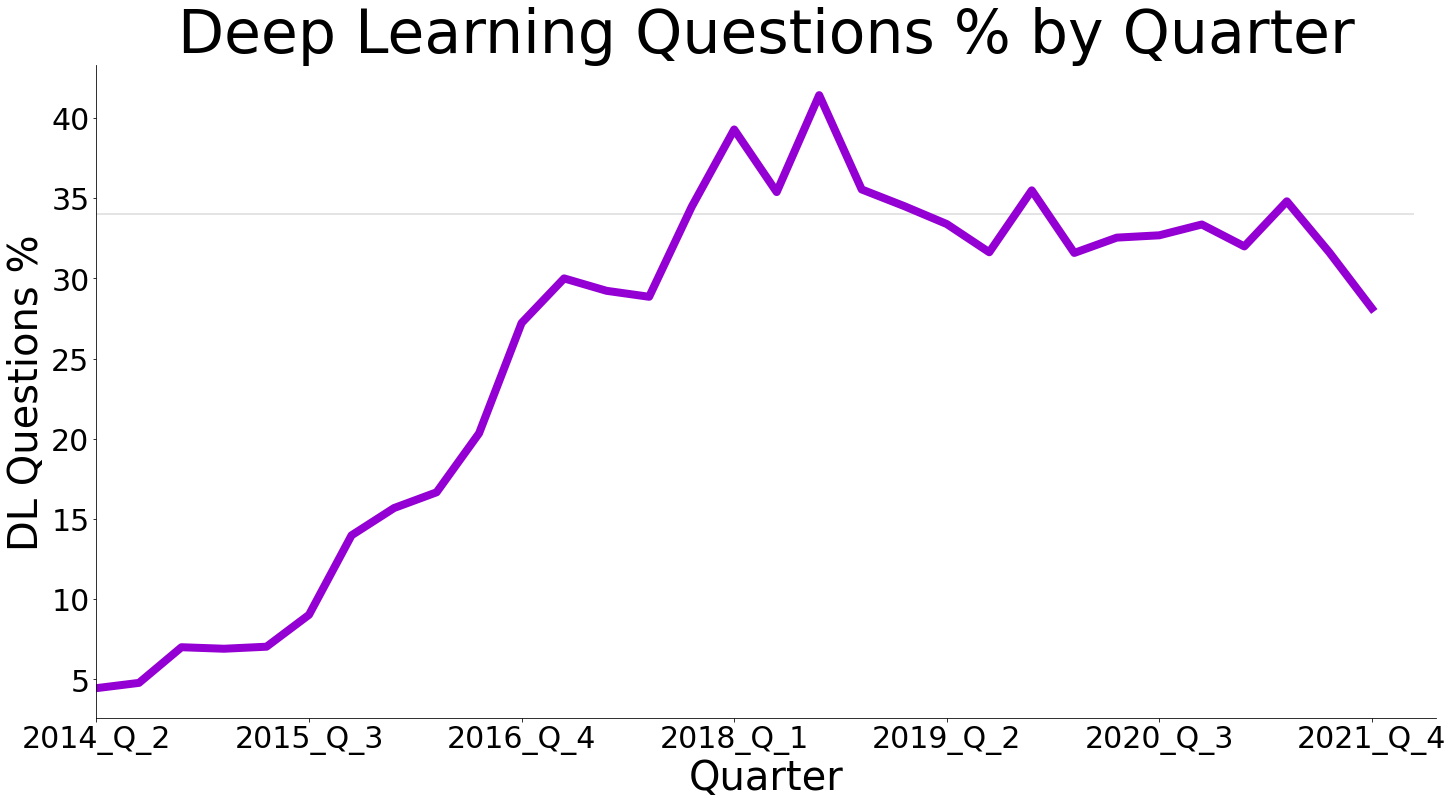

In [31]:
# CREATING A LINE PLOT FOR THE PERCENTAGE OF DL-RELATED QUESTIONS BY QUARTER
#--------------------------------------------------------------------------
N = len(questions_by_quarter)
questions_by_quarter.plot(
                          figsize=(24,12),
                          x='YearQuarter', 
                          y='dl_questions_percent',
                          kind='line', 
                          xlim=0, 
                          linestyle='-', 
                          color='darkviolet', 
                          lw=8,
                          fontsize=30, 
                          legend=False
                          )
plt.xlabel('Quarter', fontsize=40)
plt.ylabel('DL Questions %', fontsize=40)
plt.title('Deep Learning Questions % by Quarter', fontsize=60)
plt.hlines(
           y=34, 
           xmin=0, 
           xmax= N,
           color='gainsboro',
           )
sns.despine()

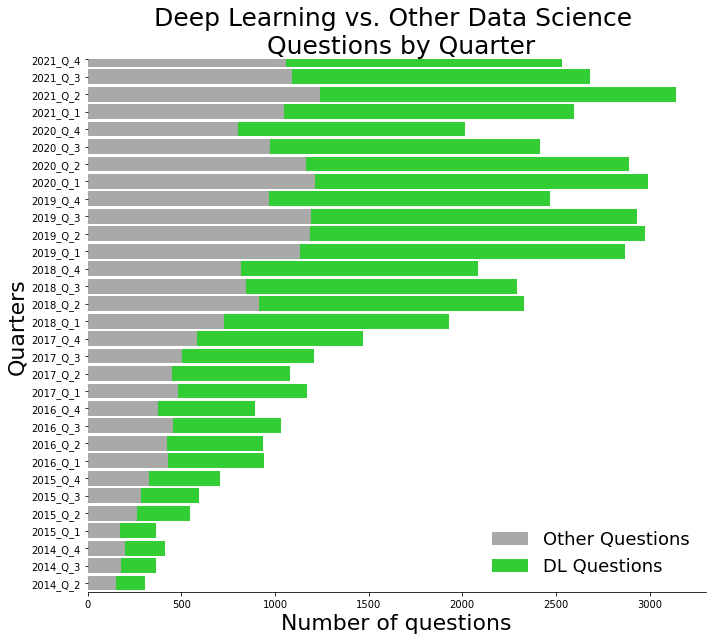

In [32]:
# CREATING A STACKED HORIZONTAL BAR PLOT FOR DL-RELATED AND OTHER QUESTIONS
#--------------------------------------------------------------------------
# Data to plot
other_Q = questions_by_quarter['all_questions']-questions_by_quarter['dl_questions']
dl_Q = questions_by_quarter['all_questions']

# X locations for the groups
ind = np.arange(N)

# Bar width 
width = 0.85

# Plotting the results
fig = plt.figure(figsize=(10,9))
p1 = plt.barh(
              ind, 
              other_Q, 
              width, 
              color = 'darkgray'
              )
p2 = plt.barh(
              ind, 
              dl_Q, 
              width, 
              color = 'limegreen',
              left=other_Q
              )
plt.title('Deep Learning vs. Other Data Science \n Questions by Quarter', fontsize = 25)
plt.xlabel('Number of questions', fontsize=22)
plt.ylabel('Quarters', fontsize=22)
plt.xticks(fontsize=10)
plt.yticks(ind, questions_by_quarter['YearQuarter'], fontsize=10)
plt.legend(
           (p1[0], p2[0]), 
           ('Other Questions', 'DL Questions'), 
           frameon=False, 
           fontsize=18, 
           loc=4
           )
plt.ylim(-0.5,30)
plt.tight_layout()
sns.despine(left=True)
plt.show()
print('\n')

# Conclusion


These 2 graphs give us some interesting insights:
- The number of data science questions in general has been constantly increasing over the whole time of existence of the DSSE (from 2014). A noticeable breakthrough happened in the beginning of 2018 (as a possible way forward, it could be interesting to investigate potential reasons for this growing of interest).
- From Q4 2018 to Q1 2019 , there was a significant increase in the number of QS related to DS, possibly this could be due to Covid-19 and more people were forced into lockdown
- The same pattern repeated from Q3 2020 to Q4 2021, where there was a drop when lockdown mandate was lifted and an increase when it was enforced
- Overall, the average percentage of data science question related to `deep learning` has been fairly consistent throughout the year